In [3]:
from moviegraphbenchmark import load_data
ds = load_data(pair="imdb-tmdb",data_path="DATA")

INFO:moviegraphbenchmark:Data already present in DATA
INFO:moviegraphbenchmark:Loading from data path: DATA


In [9]:
ds.attr_triples_2.head(10)



,head,relation,tail
0,https://www.scads.de/movieBenchmark/resource/T...,https://www.scads.de/movieBenchmark/ontology/name,Dean DeBlois^^<http://www.w3.org/2001/XMLSchem...
1,https://www.scads.de/movieBenchmark/resource/T...,https://www.scads.de/movieBenchmark/ontology/t...,Episode 7^^<http://www.w3.org/2001/XMLSchema#s...
2,https://www.scads.de/movieBenchmark/resource/T...,https://www.scads.de/movieBenchmark/ontology/r...,2009-01-01^^<http://www.w3.org/2001/XMLSchema#...
3,https://www.scads.de/movieBenchmark/resource/T...,http://dbpedia.org/ontology/abstract,Part two of two. Despite arresting four people...
4,https://www.scads.de/movieBenchmark/resource/T...,https://www.scads.de/movieBenchmark/ontology/o...,Le Magicien^^<http://www.w3.org/2001/XMLSchema...
5,https://www.scads.de/movieBenchmark/resource/T...,https://www.scads.de/movieBenchmark/ontology/t...,El Maniquí^^<http://www.w3.org/2001/XMLSchema#...
6,https://www.scads.de/movieBenchmark/resource/T...,https://www.scads.de/movieBenchmark/ontology/t...,The Bellicose Proxy^^<http://www.w3.org/2001/X...
7,https://www.scads.de/movieBenchmark/resource/T...,http://dbpedia.org/ontology/releaseDate,2014-02-14^^<http://www.w3.org/2001/XMLSchema#...
8,https://www.scads.de/movieBenchmark/resource/T...,https://www.scads.de/movieBenchmark/ontology/s...,Returning Series^^<http://www.w3.org/2001/XMLS...
9,https://www.scads.de/movieBenchmark/resource/T...,https://www.scads.de/movieBenchmark/ontology/name,Yiu-Tsou Cheung^^<http://www.w3.org/2001/XMLSc...


In [25]:
import torch
from torch_geometric.datasets import IMDB
import torch_geometric.transforms as T 

# Download the dataset
dataset = IMDB(root='data/imdb',transform=T.NormalizeFeatures())

# Convert the HeteroData to a homogeneous graph
data=dataset[0]

data

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278]
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)

In [37]:
x=torch.cat([data["movie"].x,data["director"].x,data["actor"].x])
x.shape


torch.Size([11616, 3066])

In [42]:
data.edge_index_dict

{('movie',
  'to',
  'director'): tensor([[   0,    1,    2,  ..., 4275, 4276, 4277],
         [ 789,  680, 1757,  ..., 1781,  166,  399]]),
 ('movie',
  'to',
  'actor'): tensor([[   0,    0,    0,  ..., 4277, 4277, 4277],
         [ 674, 2394, 5129,  ...,  100, 1078, 1439]]),
 ('director',
  'to',
  'movie'): tensor([[   0,    1,    2,  ..., 2078, 2079, 2080],
         [3972, 3751, 3090,  ..., 3246, 3652, 4143]]),
 ('actor',
  'to',
  'movie'): tensor([[   0,    0,    0,  ..., 5256, 5256, 5256],
         [ 555,  703, 1147,  ..., 1765, 2086, 2540]])}

In [68]:
edge_index=torch.cat([data[("movie", "to", "director")].edge_index,data[("movie", "to", "actor")].edge_index,data[("director", "to", "movie")].edge_index,data[("actor", "to", "movie")].edge_index],dim=1)
edge_index.shape

torch.Size([2, 34212])

In [69]:
edge_index=edge_index.unique(dim=1)

In [70]:
from torch_geometric.data import Data


input_data=Data(x=x,edge_index=edge_index)
input_data

Data(x=[11616, 3066], edge_index=[2, 34188])

In [71]:

from torch_geometric.utils import train_test_split_edges


input_data=train_test_split_edges(input_data,val_ratio=0.1,test_ratio=0.2)


c:\anaconda\envs\pytorch\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [72]:
from torch_geometric.nn import VGAE
from torch_geometric.nn import GCNConv


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)
    



In [83]:
out_channels = 20
num_features = input_data.num_features
epochs = 400


model = VGAE(VariationalGCNEncoder(num_features, out_channels))  # new line

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = input_data.x.to(device)
train_pos_edge_index = input_data.train_pos_edge_index.to(device)
val_pos_edge_index=input_data.val_pos_edge_index.to(device)
test_pos_edge_index=input_data.test_pos_edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [84]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    
    loss = loss + (1 / input_data.num_nodes) * model.kl_loss()  # new line
    loss.backward()
    optimizer.step()
    return float(loss)


def test(test,pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, test)
    return model.test(z, pos_edge_index, neg_edge_index)

In [86]:
from torch.utils.tensorboard import SummaryWriter
from  tqdm.auto import tqdm

writer = SummaryWriter('runs/VGAE_experiment_IMDB'+'20d_400_epochs_2')

for epoch in tqdm(range(1, epochs + 1)):
    loss = train()
    auc, ap = test(test_pos_edge_index,input_data.test_pos_edge_index, input_data.test_neg_edge_index)
    #print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    #tqdm.set_description(f'Epoch {str(epoch)}, Train Loss: {str(loss)}, Train AP: {str(ap)}, auc: {str(auc)}')
    
    writer.add_scalar('auc train',auc,epoch) # new line
    writer.add_scalar('ap train',ap,epoch)   # new line
    writer.add_scalar('loss',loss,epoch)



100%|██████████| 400/400 [02:04<00:00,  3.22it/s]


In [88]:
torch.save(model.state_dict(), 'models/VGAE_experiment_IMDB'+'20d_400_epochs')

In [97]:

latent_space=model.encode(input_data.x,train_pos_edge_index)
latent_space = latent_space.detach().numpy()
latent_space

array([[ 0.4460761 ,  0.2925882 , -0.35987073, ...,  0.39846468,
        -0.30838662,  0.4192141 ],
       [ 0.34631002,  0.35637385, -0.09218901, ...,  0.26474082,
        -0.13697185,  0.35040012],
       [ 0.2877815 ,  0.34571308, -0.10854623, ...,  0.294645  ,
        -0.27773848,  0.41967347],
       ...,
       [-0.14537042, -0.18813905, -0.04543076, ..., -0.09786035,
        -0.03228566, -0.2599634 ],
       [-0.17132288, -0.11243628,  0.29255438, ..., -0.19438043,
         0.13042957, -0.26825064],
       [-0.24246041, -0.21080086, -0.05785967, ...,  0.05894051,
         0.00316355,  0.02363967]], dtype=float32)

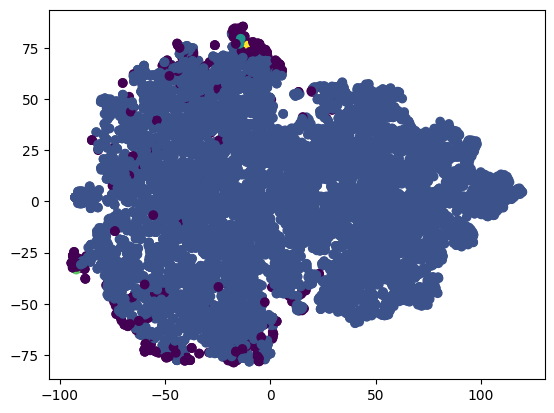

MemoryError: Unable to allocate 10.1 GiB for an array with shape (11616, 11616, 20) and data type float32

In [98]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


dbscan = DBSCAN(eps=0.5, min_samples=5)
cluster_labels = dbscan.fit_predict(latent_space)

# Apply t-SNE dimensionality reduction technique to reduce the dimensionality of the latent space embeddings
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
tsne_embeddings = tsne.fit_transform(latent_space)

# Plot the reduced embeddings and color code the points based on their cluster assignments
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels)
plt.show()

# Identify overlapping regions by finding pairs of points that belong to different clusters but are located close together
pairwise_distances = np.linalg.norm(latent_space[:, np.newaxis] - latent_space, axis=-1)
overlapping_points = np.argwhere((pairwise_distances < 0.2) & (cluster_labels[:, np.newaxis] != cluster_labels)).flatten()
print("Overlapping points:", overlapping_points)